In [ ]:
import os
import random
import pathlib
import time
import struct
import operator


import numpy as np
import pandas as pd
import scipy
import scipy.fft
import phik

from matplotlib import pyplot as plt
import seaborn as sns

import sqlite3
import json

# import torch as torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm.notebook import tqdm

from datasets import load_dataset, load_metric

In [253]:
PROJECT_FOLDER = os.path.abspath(os.path.join(pathlib.Path().resolve(), os.pardir))

TITANIC_NOTEBOOKS_FOLDER = pathlib.Path().resolve()

TITANIC_RESULTS_FOLDER = os.path.join(PROJECT_FOLDER, 'titanic_results_folder')

if not os.path.isdir(TITANIC_RESULTS_FOLDER):
   os.makedirs(TITANIC_RESULTS_FOLDER)

TITANIC_INITIAL_DATA_PATH = os.path.join(TITANIC_RESULTS_FOLDER, 'titanic_initial_data.csv')
TITANIC_PROCESSED_DATA_PATH = os.path.join(TITANIC_RESULTS_FOLDER, 'titanic_processed_data.csv')

In [254]:
df = sns.load_dataset('titanic')
df_processed=df.copy()
df.to_csv(TITANIC_INITIAL_DATA_PATH, index=False)

In [255]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [256]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [257]:
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In [258]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [259]:
#Pirson Correlation
df._get_numeric_data().corr()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.557080,-0.203367
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.094035,0.135207
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.280328,0.198270
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.253586,-0.584471
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.349943,-0.583398
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182024,-0.271832
adult_male,-0.557080,0.094035,0.280328,-0.253586,-0.349943,-0.182024,1.000000,0.404744
alone,-0.203367,0.135207,0.198270,-0.584471,-0.583398,-0.271832,0.404744,1.000000


In [260]:
#Phik correlation
phik_matrix = df.phik_matrix()
phik_matrix

interval columns not set, guessing: ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
survived,1.000000,0.205464,0.750322,0.203348,0.175652,0.147080,0.265387,0.100349,0.205464,0.352948,0.764495,0.101669,0.100349,0.999994,0.306491
pclass,0.205464,1.000000,0.078281,0.409334,0.216296,0.033361,0.588122,0.584054,1.000000,0.380083,0.057740,0.713564,0.584054,0.205464,0.076925
sex,0.750322,0.078281,1.000000,0.130602,0.192974,0.231568,0.176741,0.068222,0.078281,0.699361,0.989134,0.225356,0.068222,0.750322,0.453353
age,0.203348,0.409334,0.130602,1.000000,0.406231,0.405800,0.166983,0.109913,0.409334,0.773458,0.511288,0.374095,0.109913,0.203348,0.458638
sibsp,0.175652,0.216296,0.192974,0.406231,1.000000,0.589912,0.497583,0.137069,0.216296,0.486444,0.302998,0.264976,0.137069,0.175652,0.773836
parch,0.147080,0.033361,0.231568,0.405800,0.589912,1.000000,0.337206,0.077919,0.033361,0.499134,0.367245,0.301152,0.077919,0.147080,0.637895
fare,0.265387,0.588122,0.176741,0.166983,0.497583,0.337206,1.000000,0.280664,0.588122,0.232134,0.153343,0.476480,0.280664,0.265387,0.285286
embarked,0.100349,0.584054,0.068222,0.109913,0.137069,0.077919,0.280664,1.000000,0.584054,0.246100,0.060900,0.217207,1.000000,0.100349,0.066504
class,0.205464,1.000000,0.078281,0.409334,0.216296,0.033361,0.588122,0.584054,1.000000,0.380083,0.057740,0.713564,0.584054,0.205464,0.076925
who,0.352948,0.380083,0.699361,0.773458,0.486444,0.499134,0.232134,0.246100,0.380083,1.000000,1.000000,0.378650,0.246100,0.352948,0.278429


In [261]:
# find any corellated columns from phik_matrix
# we must check all values beyond diagonal, if they are close to 1
number_of_columns = df.columns.values.size
corelated_columns = []
for i in range(number_of_columns):
    for j in range(i+1,number_of_columns):
        if phik_matrix.iloc[j,i] >= 0.95:
            current_row = phik_matrix.index.values[j]
            current_column = phik_matrix.columns.values[i]
            corelated_columns.append([current_row, current_column])
print(f'columns with phik corellation >= 0.95:\n{corelated_columns}')

columns with phik corellation >= 0.95:
[['alive', 'survived'], ['class', 'pclass'], ['adult_male', 'sex'], ['embark_town', 'embarked'], ['adult_male', 'who']]


In [262]:
# are there any rows: pclass == 1, and class != First?
print( (df['pclass'].to_numpy()==1) & (df['class'].to_numpy() != 'First') )

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [263]:
#check if all values of pclass and class column matches with each other
first=np.argwhere((df['pclass'].to_numpy()==1) & (df['class'].to_numpy() != 'First')).shape[0]
second= np.argwhere((df['pclass'].to_numpy()==2) & (df['class'].to_numpy() != 'Second')).shape[0]
third= np.argwhere((df['pclass'].to_numpy()==3) & (df['class'].to_numpy() != 'Third')).shape[0]
print("first: %d, second: %d, third: %d" %(first, second,third))

first: 0, second: 0, third: 0


In [264]:
df_processed = df_processed.drop('pclass', axis= 1)

In [265]:
print( (df['embarked'].isnull()) & (df['embark_town'].isnull()) )


0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 891, dtype: bool


In [266]:
#check if the missing values for embark and embarked column are for the same person,
#otherwise both columns could be filled based on the other column's value
df['embarked'][(df['embarked'].isnull()) & (df['embark_town'].isnull())]

61     NaN
829    NaN
Name: embarked, dtype: object

In [267]:
df_processed = df_processed.drop([61,829], axis=0)

In [268]:
#check all values of embarked and embark_towns column matches with each other
S = np.argwhere((df['embarked'].to_numpy()=='S') & (df['embark_town'].to_numpy() != 'Southampton')).shape[0]
C = np.argwhere((df['embarked'].to_numpy()=='C') & (df['embark_town'].to_numpy() != 'Cherbourg')).shape[0]
Q = np.argwhere((df['embarked'].to_numpy()=='Q') & (df['embark_town'].to_numpy() != 'Queenstown')).shape[0]
print("S: %d, C: %d, Q: %d" %(S, C,Q))

S: 0, C: 0, Q: 0


In [269]:
#since embarked and embark_town column values gives the same info, we can drop one of them
df_processed=df_processed.drop('embarked',axis= 1)

In [270]:
#crosscheck the data is correct in survived column by crosschecking it withp alive column.
df['survived'][(df['survived']==1) & (df['alive']=='no')]

Series([], Name: survived, dtype: int64)

In [271]:
#drooping alive column as survived provided the same info
df_processed = df_processed.drop('alive', axis=1)

In [272]:
#check if there are any missing values for age of a child so that they could be filled appropriately
df['age'][(df['age'].isnull()) & (df['who']=='child')]

Series([], Name: age, dtype: float64)

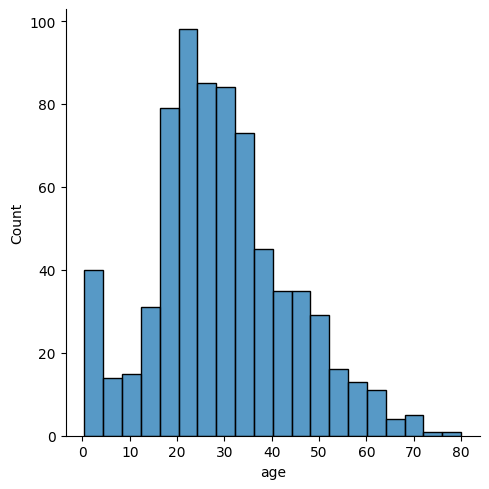

In [273]:
#no missing values for age of a child, now look at distplot of age
sns.displot(df['age'])

In [274]:
#The distplot of age is approximately normal, so it would be approriate to fill the missing values with mean
df_processed['age'] = df_processed['age'].fillna(df_processed['age'].mean())

In [275]:
df['deck'].unique()

[NaN, 'C', 'E', 'G', 'D', 'A', 'B', 'F']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']

<Axes: xlabel='deck', ylabel='survived'>

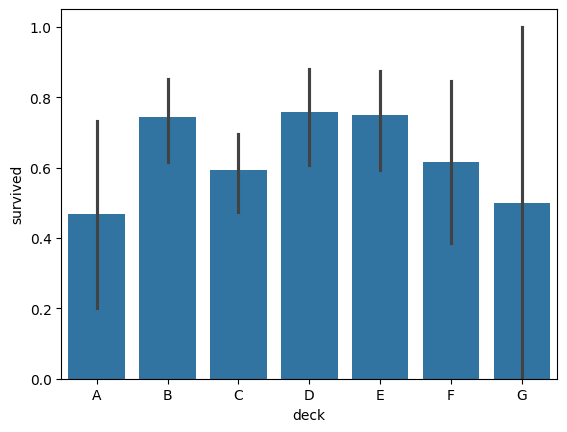

In [276]:
#check if deck is impactfull on alive
sns.barplot(df.iloc[ map(operator.not_, df['deck'].isnull()) ], x='deck', y='survived')

In [277]:
df.iloc[(df['deck']=='G').to_numpy()][['survived','deck']]

,survived,deck
10,1,G
205,0,G
251,0,G
394,1,G


In [278]:
df.iloc[(df['deck']=='A').to_numpy()][['survived','deck']]

,survived,deck
23,1,A
96,0,A
174,0,A
185,0,A
209,1,A
284,0,A
445,1,A
475,0,A
556,1,A
583,0,A


In [279]:
#we can drop this column for now
df_processed = df_processed.drop('deck', axis=1)

In [280]:
df_processed.to_csv(TITANIC_PROCESSED_DATA_PATH, index=False)

In [281]:
df_processed = pd.read_csv(TITANIC_PROCESSED_DATA_PATH)

In [282]:
df_processed

,survived,sex,age,sibsp,parch,fare,class,who,adult_male,embark_town,alone
0,0,male,22.000000,1,0,7.2500,Third,man,True,Southampton,False
1,1,female,38.000000,1,0,71.2833,First,woman,False,Cherbourg,False
2,1,female,26.000000,0,0,7.9250,Third,woman,False,Southampton,True
3,1,female,35.000000,1,0,53.1000,First,woman,False,Southampton,False
4,0,male,35.000000,0,0,8.0500,Third,man,True,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...
884,0,male,27.000000,0,0,13.0000,Second,man,True,Southampton,True
885,1,female,19.000000,0,0,30.0000,First,woman,False,Southampton,True
886,0,female,29.642093,1,2,23.4500,Third,woman,False,Southampton,False
887,1,male,26.000000,0,0,30.0000,First,man,True,Cherbourg,True
